In [18]:
train_paths, test_paths, train_labels, test_labels =train_test_split(data_path, data_labels, test_size=0.2, random_state=42)

In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
import numpy as np 
import pandas as pd
import os
import shutil
import cv2
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import Xception
import xml.etree.ElementTree as ET

In [3]:
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageEnhance

from tqdm.notebook import tqdm

In [22]:
XML_PATH = os.path.join( "annotations/")
IMG_PATH = os.path.join( "path/")
XML_FILES = [os.path.join(XML_PATH, f) for f in os.listdir(XML_PATH)]

In [23]:
class XmlParser(object):

    def __init__(self,xml_file):

        self.xml_file = xml_file
        self._root = ET.parse(self.xml_file).getroot()
        self._objects = self._root.findall("object")
        # path to the image file as describe in the xml file
        self.img_path = os.path.join(IMG_PATH, self._root.find('filename').text)
        # image id 
        self.image_id = self._root.find("filename").text
        # names of the classes contained in the xml file
        self.names = self._get_names()
        # coordinates of the bounding boxes
        self.boxes = self._get_bndbox()

    def parse_xml(self):
        """"Parse the xml file returning the root."""
    
        tree = ET.parse(self.xml_file)
        return tree.getroot()

    def _get_names(self):

        names = []
        for obj in self._objects:
            name = obj.find("name")
            names.append(name.text)

        return np.array(names)

    def _get_bndbox(self):

        boxes = []
        for obj in self._objects:
            coordinates = []
            bndbox = obj.find("bndbox")
            coordinates.append(np.int32(bndbox.find("xmin").text))
            coordinates.append(np.int32(bndbox.find("ymin").text))
            coordinates.append(np.int32(bndbox.find("xmax").text))
            coordinates.append(np.int32(bndbox.find("ymax").text))
            boxes.append(coordinates)

        return np.array(boxes)



In [24]:
def xml_files_to_df(xml_files):   
    names = []
    boxes = []
    image_id = []
    xml_path = []
    img_path = []
    for file in xml_files:
        xml = XmlParser(file)
        names.extend(xml.names)
        boxes.extend(xml.boxes)
        image_id.extend([xml.image_id] * len(xml.names))
        xml_path.extend([xml.xml_file] * len(xml.names))
        img_path.extend([xml.img_path] * len(xml.names))
    a = {"image_id": image_id,
         "names": names,
         "boxes": boxes,
         "xml_path":xml_path,
         "img_path":img_path}
    
    df = pd.DataFrame.from_dict(a, orient='index')
    df = df.transpose()
    
    return df

df = xml_files_to_df(XML_FILES)
df.head()

,image_id,names,boxes,xml_path,img_path
0,new_data0.jpeg,rouille,"[448, 115, 751, 238]",annotations/new_data0.xml,path/new_data0.jpeg
1,new_data0.jpeg,rouille,"[478, 663, 568, 834]",annotations/new_data0.xml,path/new_data0.jpeg
2,new_data0.jpeg,rouille,"[662, 717, 841, 1002]",annotations/new_data0.xml,path/new_data0.jpeg
3,new_data0.jpeg,rouille,"[528, 776, 636, 1125]",annotations/new_data0.xml,path/new_data0.jpeg
4,new_data0.jpeg,rouille,"[52, 517, 420, 635]",annotations/new_data0.xml,path/new_data0.jpeg


In [25]:
df.shape

(2464, 5)

In [26]:
def group_boxes(group):
    boundaries = group['boxes']
    return boundaries.values

data = df.groupby('image_id').apply(group_boxes)

In [27]:
data

image_id
new_data0.jpeg      [[448, 115, 751, 238], [478, 663, 568, 834], [...
new_data1.jpeg      [[127, 100, 575, 396], [313, 254, 933, 490], [...
new_data10.jpeg     [[267, 277, 641, 533], [245, 698, 602, 934], [...
new_data100.jpeg    [[196, 476, 452, 619], [234, 802, 380, 1176], ...
new_data101.jpeg    [[237, 471, 507, 684], [617, 507, 924, 815], [...
                                          ...                        
new_data95.jpeg     [[634, 584, 749, 888], [190, 441, 328, 687], [...
new_data96.jpeg     [[372, 480, 430, 577], [413, 514, 540, 750], [...
new_data97.jpeg     [[276, 908, 406, 1280], [621, 635, 792, 835], ...
new_data98.jpeg     [[302, 357, 429, 765], [486, 546, 669, 1060], ...
new_data99.jpeg     [[319, 619, 432, 888], [533, 692, 832, 960], [...
Length: 617, dtype: object

In [28]:
train_image_ids = np.unique(data.index.values)[0:494]
val_image_ids = np.unique(data.index.values)[494:617]

In [78]:
train_image_ids

array(['new_data0.jpeg', 'new_data1.jpeg', 'new_data10.jpeg',
       'new_data100.jpeg', 'new_data101.jpeg', 'new_data102.jpeg',
       'new_data103.jpeg', 'new_data104.jpeg', 'new_data105.jpeg',
       'new_data106.jpeg', 'new_data107.jpeg', 'new_data108.jpeg',
       'new_data109.jpeg', 'new_data11.jpeg', 'new_data110.jpeg',
       'new_data111.jpeg', 'new_data112.jpeg', 'new_data113.jpeg',
       'new_data114.jpeg', 'new_data115.jpeg', 'new_data116.jpeg',
       'new_data117.jpeg', 'new_data118.jpeg', 'new_data119.jpeg',
       'new_data12.jpeg', 'new_data120.jpeg', 'new_data121.jpeg',
       'new_data122.jpeg', 'new_data123.jpeg', 'new_data124.jpeg',
       'new_data125.jpeg', 'new_data126.jpeg', 'new_data127.jpeg',
       'new_data128.jpeg', 'new_data129.jpeg', 'new_data13.jpeg',
       'new_data130.jpeg', 'new_data131.jpeg', 'new_data132.jpeg',
       'new_data133.jpeg', 'new_data134.jpeg', 'new_data135.jpeg',
       'new_data136.jpeg', 'new_data137.jpeg', 'new_data138.jpeg',
   

In [30]:
data['new_data0.jpeg']

array([array([448, 115, 751, 238]), array([478, 663, 568, 834]),
       array([ 662,  717,  841, 1002]), array([ 528,  776,  636, 1125]),
       array([ 52, 517, 420, 635]), array([783, 533, 956, 638])],
      dtype=object)

In [71]:
def load_image(image_id):
    image = Image.open(IMG_PATH + image_id )
    image = image.resize((240, 320))
    
    return np.asarray(image)

In [72]:
train_pixels = {}
train_labels = {}

for image_id in tqdm(train_image_ids):
    train_pixels[image_id] = load_image(image_id)
    train_labels[image_id] = data[image_id].copy()/4

  0%|          | 0/494 [00:00<?, ?it/s]

In [73]:
val_pixels = {}
val_labels = {}

for image_id in tqdm(val_image_ids):
    val_pixels[image_id] = load_image(image_id)    
    val_labels[image_id] = data[image_id].copy()/4

  0%|          | 0/123 [00:00<?, ?it/s]

In [74]:
train_labels['new_data0.jpeg']

array([array([112.  ,  28.75, 187.75,  59.5 ]),
       array([119.5 , 165.75, 142.  , 208.5 ]),
       array([165.5 , 179.25, 210.25, 250.5 ]),
       array([132.  , 194.  , 159.  , 281.25]),
       array([ 13.  , 129.25, 105.  , 158.75]),
       array([195.75, 133.25, 239.  , 159.5 ])], dtype=object)

In [75]:
def draw_bboxes(image_id, bboxes ):  
    image = Image.open(IMG_PATH+ image_id)
    image = image.resize((240, 320))
    draw = ImageDraw.Draw(image)
    for bbox in bboxes:
        draw_bbox(draw, bbox)
    return np.asarray(image)

def draw_bbox(draw, bbox):
    x, y, width, height = bbox
    draw.rectangle([x, y, width, height], width=4, outline='red')

In [76]:
def show_images(image_ids, bboxes):
    pixels = []
    
    for image_id in image_ids:
        pixels.append(
            draw_bboxes(image_id, bboxes[image_id])
        )
    
    num_of_images = len(image_ids)
    fig, axes = plt.subplots(
        1, 
        num_of_images, 
        figsize=(5 * num_of_images, 5* num_of_images)
    )
    
    for i, image_pixels in enumerate(pixels):
        axes[i].imshow(image_pixels)

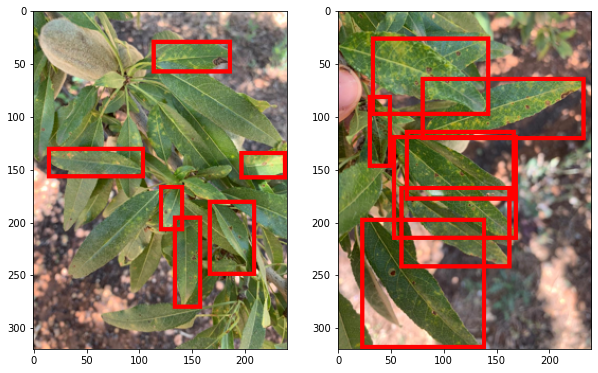

In [77]:
show_images(train_image_ids[0:2], train_labels)

## data pipeline

In [143]:
BATCH_SIZE = 16

In [438]:
class DataGenerator(keras.utils.Sequence):
    
    def __init__(self, image_ids, image_pixels, labels=None, batch_size=8, shuffle=False, augment=False):
        self.image_ids = image_ids
        self.image_pixels = image_pixels
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()
        self.image_grid = self.form_image_grid()
        

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_ids))

        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    def form_image_grid(self):    
        image_grid = np.zeros((32, 32, 4))

        # x, y, width, height
        cell = [0, 0, 320 / 32, 240 / 32] 

        for i in range(0, 32):
            for j in range(0, 16):
                image_grid[i,j] = cell

                cell[0] = cell[0] + cell[2]

            cell[0] = 0
            cell[1] = cell[1] + cell[3]

        return image_grid
    
    def __data_generation(self, batch_ids):
        X, y = [], []

        # Generate data
        for i, image_id in enumerate(batch_ids):
            pixels =self.image_pixels[image_id]
            bboxes = self.labels[image_id]
            
            
            if self.augment:     
                pixels, bboxes = self.augment_image(pixels, bboxes)
            else:
                pixels = self.contrast_image(pixels)
                bboxes = self.form_label_grid(bboxes)
            
            
            X.append(pixels)
            y.append(bboxes)

         
        return np.array(X), np.array(y)

    

    def augment_image(self, pixels, bboxes):
        bbox_labels = np.ones(len(bboxes))

        aug_result = self.train_augmentations(image=pixels, bboxes=bboxes, labels=bbox_labels)

        bboxes = self.form_label_grid(aug_result['bboxes'])

        return np.array(aug_result['image']) / 239, bboxes


    def contrast_image(self, pixels):        
        aug_result = self.val_augmentations(image=pixels)
        return np.array(aug_result['image']) / 239


    def __len__(self):
        return int(np.floor(len(self.image_ids) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        batch_ids = [self.image_ids[i] for i in indexes]

        X, y = self.__data_generation(batch_ids)

        return X, y
    def form_label_grid(self, bboxes):
        label_grid = np.zeros((32, 32, 10))

        for i in range(0, 32):
            for j in range(0, 32):
                cell = self.image_grid[i,j]
                label_grid[i,j] = self.rect_intersect(cell, bboxes)

        return label_grid
    def rect_intersect(self, cell, bboxes): 
        cell_x, cell_y, cell_width, cell_height = cell
        cell_x_max = cell_x + cell_width 
        cell_y_max = cell_y + cell_height

        anchor_one = np.array([0, 0, 0, 0, 0])
        anchor_two = np.array([0, 0, 0, 0, 0])

        # check all boxes
        for bbox in bboxes:
            box_x, box_y, box_width, box_height = bbox
            box_x_centre = box_x + (box_width / 2)
            box_y_centre = box_y + (box_height / 2)

            if(box_x_centre >= cell_x and box_x_centre < cell_x_max and box_y_centre >= cell_y and box_y_centre < cell_y_max):

                                # anchor one is empty
                if anchor_one[0] == 0:
                    anchor_one = self.yolo_shape(
                        [box_x, box_y, box_width, box_height],
                        [cell_x, cell_y, cell_width, cell_height]
                )

                # anchor one is filled, anchor two is empty           
                elif anchor_two[0] == 0:
                    anchor_two = self.yolo_shape(
                        [box_x, box_y, box_width, box_height],
                        [cell_x, cell_y, cell_width, cell_height]
                )

                # both are filled (MAX 2 anchor boxes per grid)   
                else:
                    break

        return np.concatenate((anchor_one, anchor_two), axis=None)


    def yolo_shape(self, box, cell):
        box_x, box_y, box_width, box_height = box
        cell_x, cell_y, cell_width, cell_height = cell

        # top left x,y to centre x,y
        box_x = box_x + (box_width / 2)
        box_y = box_y + (box_height / 2)

        # offset bbox x,y to cell x,y
        box_x = (box_x - cell_x) / cell_width
        box_y = (box_y - cell_y) / cell_height

        # bbox width,height relative to cell width,height
        box_width = box_width / 240
        box_height = box_height / 320

        return [1, box_x, box_y, box_width, box_height]


In [439]:


DataGenerator.train_augmentations = albu.Compose([
    ], 
    bbox_params={'format': 'Pascal VOC', 'label_fields': ['labels']})
DataGenerator.val_augmentations = albu.Compose([
])

In [440]:


train_generator = DataGenerator(
    train_image_ids,
    train_pixels,
    train_labels, 
    batch_size=8,
    shuffle=True,
    augment=False
)

val_generator = DataGenerator(
    val_image_ids, 
    val_pixels,
    val_labels, 
    batch_size=8,
    shuffle=False,
    augment=False
)

image_grid = train_generator.image_grid

In [441]:

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=80
    
)



Epoch 1/80


ResourceExhaustedError:  OOM when allocating tensor with shape[8,64,320,240] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model_16/batch_normalization_9/FusedBatchNormV3 (defined at <ipython-input-437-74338a851907>:1) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_98028]

Function call stack:
train_function


In [442]:
x_input = tf.keras.Input(shape=(256,256,3))

x = tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same')(x_input)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

########## block 1 ##########
x = tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x_shortcut = x

for i in range(2):
    x = tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x


########## block 2 ##########
x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x_shortcut = x

for i in range(2):
    x = tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x

########## block 3 ##########
x = tf.keras.layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x_shortcut = x

for i in range(8):
    x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x

    
########## block 4 ##########
x = tf.keras.layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x_shortcut = x

for i in range(8):
    x = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x

########## block 5 ##########
x = tf.keras.layers.Conv2D(1024, (3, 3), strides=(2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x_shortcut = x

for i in range(4):
    x = tf.keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(1024, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x

########## output layers ##########
x = tf.keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

predictions = tf.keras.layers.Conv2D(10, (1, 1), strides=(1, 1), activation='sigmoid')(x)

model = tf.keras.Model(inputs=x_input, outputs=predictions)

In [443]:
def custom_loss(y_true, y_pred):
    binary_crossentropy = prob_loss = tf.keras.losses.BinaryCrossentropy(
        reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE
    )
    
    prob_loss = binary_crossentropy(
        tf.concat([y_true[:,:,:,0], y_true[:,:,:,5]], axis=0), 
        tf.concat([y_pred[:,:,:,0], y_pred[:,:,:,5]], axis=0)
    )
    
    xy_loss = tf.keras.losses.MSE(
        tf.concat([y_true[:,:,:,1:3], y_true[:,:,:,6:8]], axis=0), 
        tf.concat([y_pred[:,:,:,1:3], y_pred[:,:,:,6:8]], axis=0)
    )
    
    wh_loss = tf.keras.losses.MSE(
        tf.concat([y_true[:,:,:,3:5], y_true[:,:,:,8:10]], axis=0), 
        tf.concat([y_pred[:,:,:,3:5], y_pred[:,:,:,8:10]], axis=0)
    )
    
    bboxes_mask = get_mask(y_true)
    
    xy_loss = xy_loss * bboxes_mask
    wh_loss = wh_loss * bboxes_mask
    
    return prob_loss + xy_loss + wh_loss


def get_mask(y_true):
    anchor_one_mask = tf.where(
        y_true[:,:,:,0] == 0, 
        0.5, 
        5.0
    )
    
    anchor_two_mask = tf.where(
        y_true[:,:,:,5] == 0, 
        0.5, 
        5.0
    )
    
    bboxes_mask = tf.concat(
        [anchor_one_mask,anchor_two_mask],
        axis=0
    )
    
    return bboxes_mask

In [444]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=optimiser, 
    loss=custom_loss
)

In [445]:
history = model.fit_generator(
    train_generator,
    validation_data=val_generator,
    epochs=80
)

Epoch 1/80


ResourceExhaustedError:  OOM when allocating tensor with shape[8,128,320,240] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model_17/leaky_re_lu_91/LeakyRelu (defined at <ipython-input-445-74338a851907>:1) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_111342]

Function call stack:
train_function


In [142]:
BATCH_SIZE = 16

train_dataset = (
tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .cache()
    .map(data_augment, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(512)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((test_paths,test_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(data_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    
)

In [83]:
LR_START = 0.00001
LR_MAX = 0.00005 
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

In [165]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow import keras

Dense_net = keras.models.load_model('xceptions')

In [187]:
Dense_net.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [428]:
x = Dense_net.get_layer("global_average_pooling2d_3").output

#x = tf.keras.layers.Dense(1024, activation='softmax')(x)
x = tf.keras.layers.Dense(8, activation='softmax')(x)
model = keras.Model(inputs = Dense_net.input,outputs=x)
model.compile( optimizer= 'adam',loss="categorical_crossentropy", metrics=["accuracy"])

In [429]:


history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=80
    
)



Epoch 1/80


ValueError: in user code:

    C:\Users\zakaria\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:855 train_function  *
        return step_function(self, iterator)
    C:\Users\zakaria\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\zakaria\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\zakaria\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\zakaria\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\zakaria\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:838 run_step  **
        outputs = model.train_step(data)
    C:\Users\zakaria\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:796 train_step
        loss = self.compiled_loss(
    C:\Users\zakaria\anaconda3\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Users\zakaria\anaconda3\lib\site-packages\tensorflow\python\keras\losses.py:155 __call__
        losses = call_fn(y_true, y_pred)
    C:\Users\zakaria\anaconda3\lib\site-packages\tensorflow\python\keras\losses.py:259 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\zakaria\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\zakaria\anaconda3\lib\site-packages\tensorflow\python\keras\losses.py:1643 categorical_crossentropy
        return backend.categorical_crossentropy(
    C:\Users\zakaria\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\zakaria\anaconda3\lib\site-packages\tensorflow\python\keras\backend.py:4862 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    C:\Users\zakaria\anaconda3\lib\site-packages\tensorflow\python\framework\tensor_shape.py:1161 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, None, None, None) and (None, 8) are incompatible


In [137]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        #plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

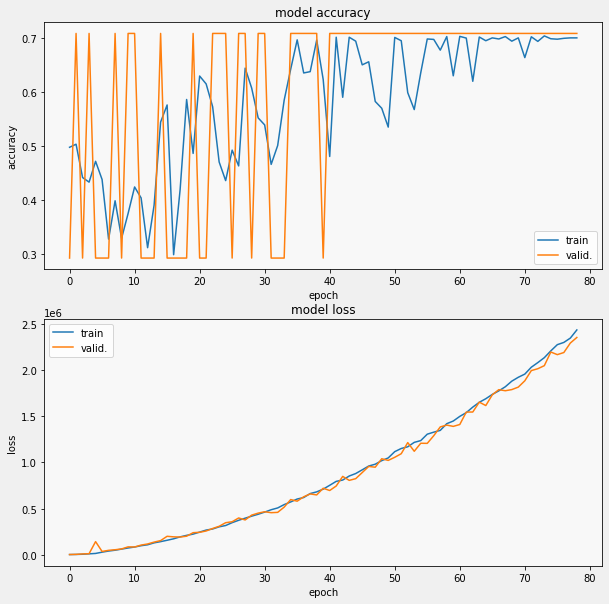

In [138]:
display_training_curves(history.history['accuracy'][1:], history.history['val_accuracy'][1:], 'accuracy', 211)
display_training_curves(history.history['loss'][1:], history.history['val_loss'][1:], 'loss', 212)

In [139]:
import pickle
with open('training_log/first_try_segmentation.pkl', 'wb') as output:
        pickle.dump(history.history, output)